In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [ ]:
group.add_argument("--seed", type=int, default=0)
group.add_argument("--save_dir", type=str, default=None)

group = parser.add_argument_group("model")
group.add_argument("--grid_size", type=int, default=64)
group.add_argument("--d_state", type=int, default=16)
group.add_argument("--n_groups", type=int, default=1)
group.add_argument("--rollout_steps", type=int, default=512)

group.add_argument("--identity_bias", type=float, default=0.)
group.add_argument("--temperature", type=float, default=1.0)

group = parser.add_argument_group("data")
group.add_argument("--prompts", type=str, default="an artificial cell,a bacterium")
group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

group = parser.add_argument_group("optimization")
group.add_argument("--bs", type=int, default=4)
group.add_argument("--pop_size", type=int, default=16)
group.add_argument("--n_iters", type=int, default=10000)
group.add_argument("--sigma", type=float, default=1.)

In [9]:
cfg_default = dict(
    seed=0, save_dir=None,
    grid_size=64, d_state=16, n_groups=1, rollout_steps=512,
    
    identity_bias=0., temperature=1.,

    prompts="", clip_model="clip-vit-base-patch32",
    
    bs=4, pop_size=16, n_iters=10000, sigma=1.
)

prompts_sweep = [
    # "a bacteria under the microscope",
    "a biological cell",
    "a diverse ecosystem of cells moving around",
    "the game of life cellular automaton",
    # "an egg",
    "the yellow sun",
    # "a fat cat",
    # "an apple",
]

identity_bias_sweep = [0., 0.5, 1., 2., 4.]
temperature_sweep = [1., 1/1.5, 1/2., 1/3., 1/4.]


cfgs = []

seed = 0
for i1, prompts in enumerate(prompts_sweep):
    for identity_bias in identity_bias_sweep:
        for temperature in temperature_sweep:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, prompts=prompts, identity_bias=identity_bias, temperature=temperature)
            cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/dnca_1/{seed}_{i1}_{identity_bias}_{temperature}")
            
            cfg.update(n_iters=5000)
            cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

100


In [10]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_target_emergence_dnca.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_target_emergence_dnca.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/dnca_1/0_0_0.0_1.0"                --grid_size=64 --d_state=16 --n_groups=1 --rollout_steps=512 --identity_bias=0.0 --temperature=1.0                --prompts="a biological cell"                          --clip_model="clip-vit-base-patch32" --bs=4 --pop_size=16 --n_iters=5000 --sigma=1.0
python train_target_emergence_dnca.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/dnca_1/0_0_0.0_0.6666666666666666" --grid_size=64 --d_state=16 --n_groups=1 --rollout_steps=512 --identity_bias=0.0 --temperature=0.6666666666666666 --prompts="a biological cell"                          --clip_model="clip-vit-base-patch32" --bs=4 --pop_size=16 --n_iters=5000 --sigma=1.0
python train_target_emergence_dnca.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/dnca_1/0_0_0.0_0.5"                --grid_size=64 --d_state=16 --n_groups=1 --rollout_steps=512 --identity_bias=0.0 --temperature=0.5 

# Visualize Results

In [11]:
import jax
import jax.numpy as jnp
import copy

In [55]:
df = []
for cfg in tqdm(cfgs):
    save_dir = cfg['save_dir']
    dfi = copy.copy(cfg)

    _, loss = util.load_pkl(cfg['save_dir'], 'best')
    dfi['loss'] = loss.item()
    df.append(dfi)
df = pd.DataFrame(df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
df

seed                                           save_dir  grid_size  \
0      0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
1      0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
2      0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
3      0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
4      0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
..   ...                                                ...        ...   
95     0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
96     0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
97     0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
98     0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   
99     0  /home/akarshkumar0101/nca-alife-data/dnca_1/0_...         64   

    d_state  n_groups  rollout_steps  identity_bias  temperature  \
0        16         1            512            0.0     1.000000   
1        16         1            512            0.0     0.666667   
2        16         1            512            0.0     0.500000   
3        16         1            512            0.0     0.333333   
4        16         1            512            0.0     0.250000   
..      ...       ...            ...            ...          ...   
95       16         1            512            4.0     1.000000   
96       16         1            512            4.0     0.666667   
97       16         1            512            4.0     0.500000   
98       16         1            512            4.0     0.333333   
99       16         1            512            4.0     0.250000   

              prompts             clip_model  bs  pop_size  n_iters  sigma  \
0   a biological cell  clip-vit-base-patch32   4        16     5000    1.0   
1   a biological cell  clip-vit-base-patch32   4        16     5000    1.0   
2   a biological cell  clip-vit-base-patch32   4        16     5000    1.0   
3   a biological cell  clip-vit-base-patch32   4        16     5000    1.0   
4   a biological cell  clip-vit-base-patch32   4        16     5000    1.0   
..                ...                    ...  ..       ...      ...    ...   
95     the yellow sun  clip-vit-base-patch32   4        16     5000    1.0   
96     the yellow sun  clip-vit-base-patch32   4        16     5000    1.0   
97     the yellow sun  clip-vit-base-patch32   4        16     5000    1.0   
98     the yellow sun  clip-vit-base-patch32   4        16     5000    1.0   
99     the yellow sun  clip-vit-base-patch32   4        16     5000    1.0   

        loss  
0  -0.305314  
1  -0.311852  
2  -0.280931  
3  -0.281093  
4  -0.277727  
..       ...  
95 -0.285795  
96 -0.303563  
97 -0.309971  
98 -0.281460  
99 -0.311153  

[100 rows x 15 columns]

<Axes: xlabel='temperature', ylabel='identity_bias'>

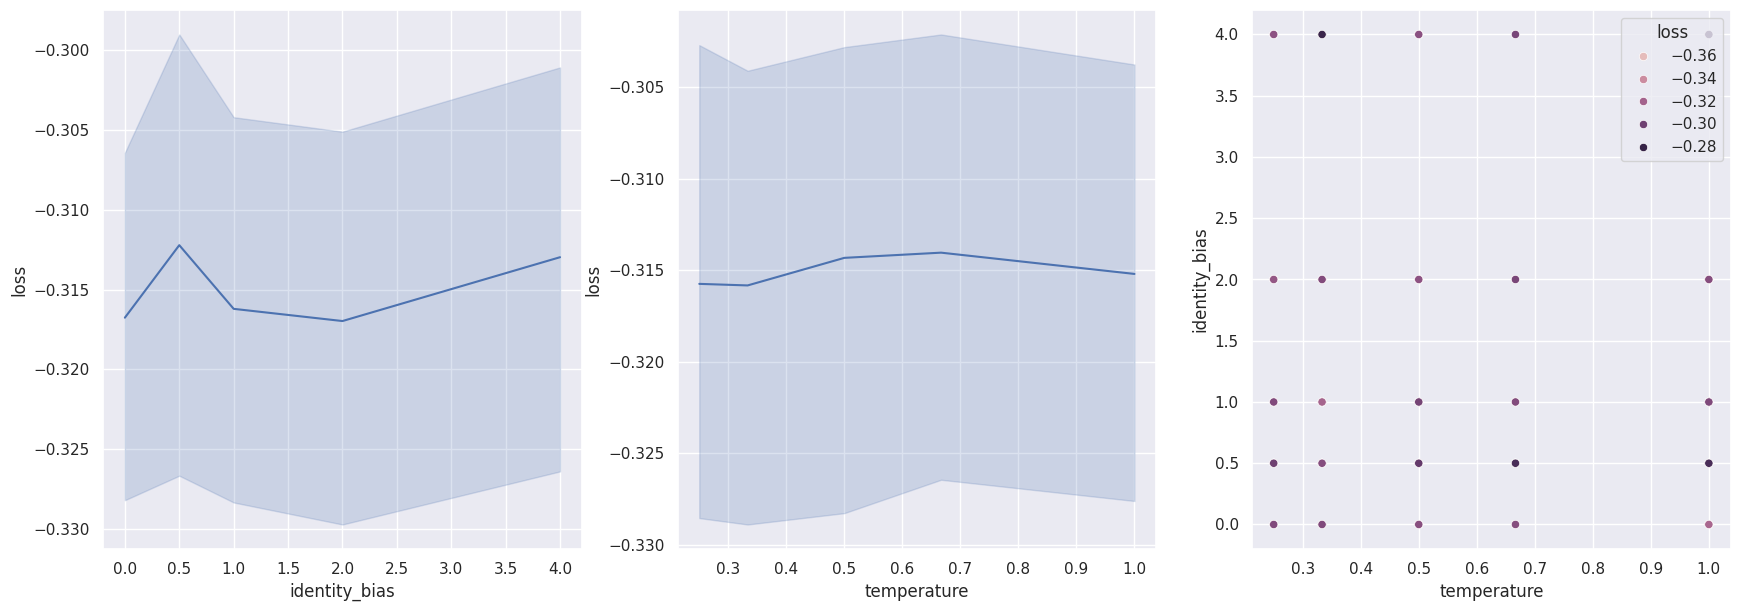

In [57]:
plt.figure(figsize=(21, 7))
plt.subplot(131)
sns.lineplot(data=df, x='identity_bias', y='loss')
plt.subplot(132)
sns.lineplot(data=df, x='temperature', y='loss')
plt.subplot(133)
sns.scatterplot(data=df, x='temperature', y='identity_bias', hue='loss')

  0%|          | 0/5 [00:00<?, ?it/s]

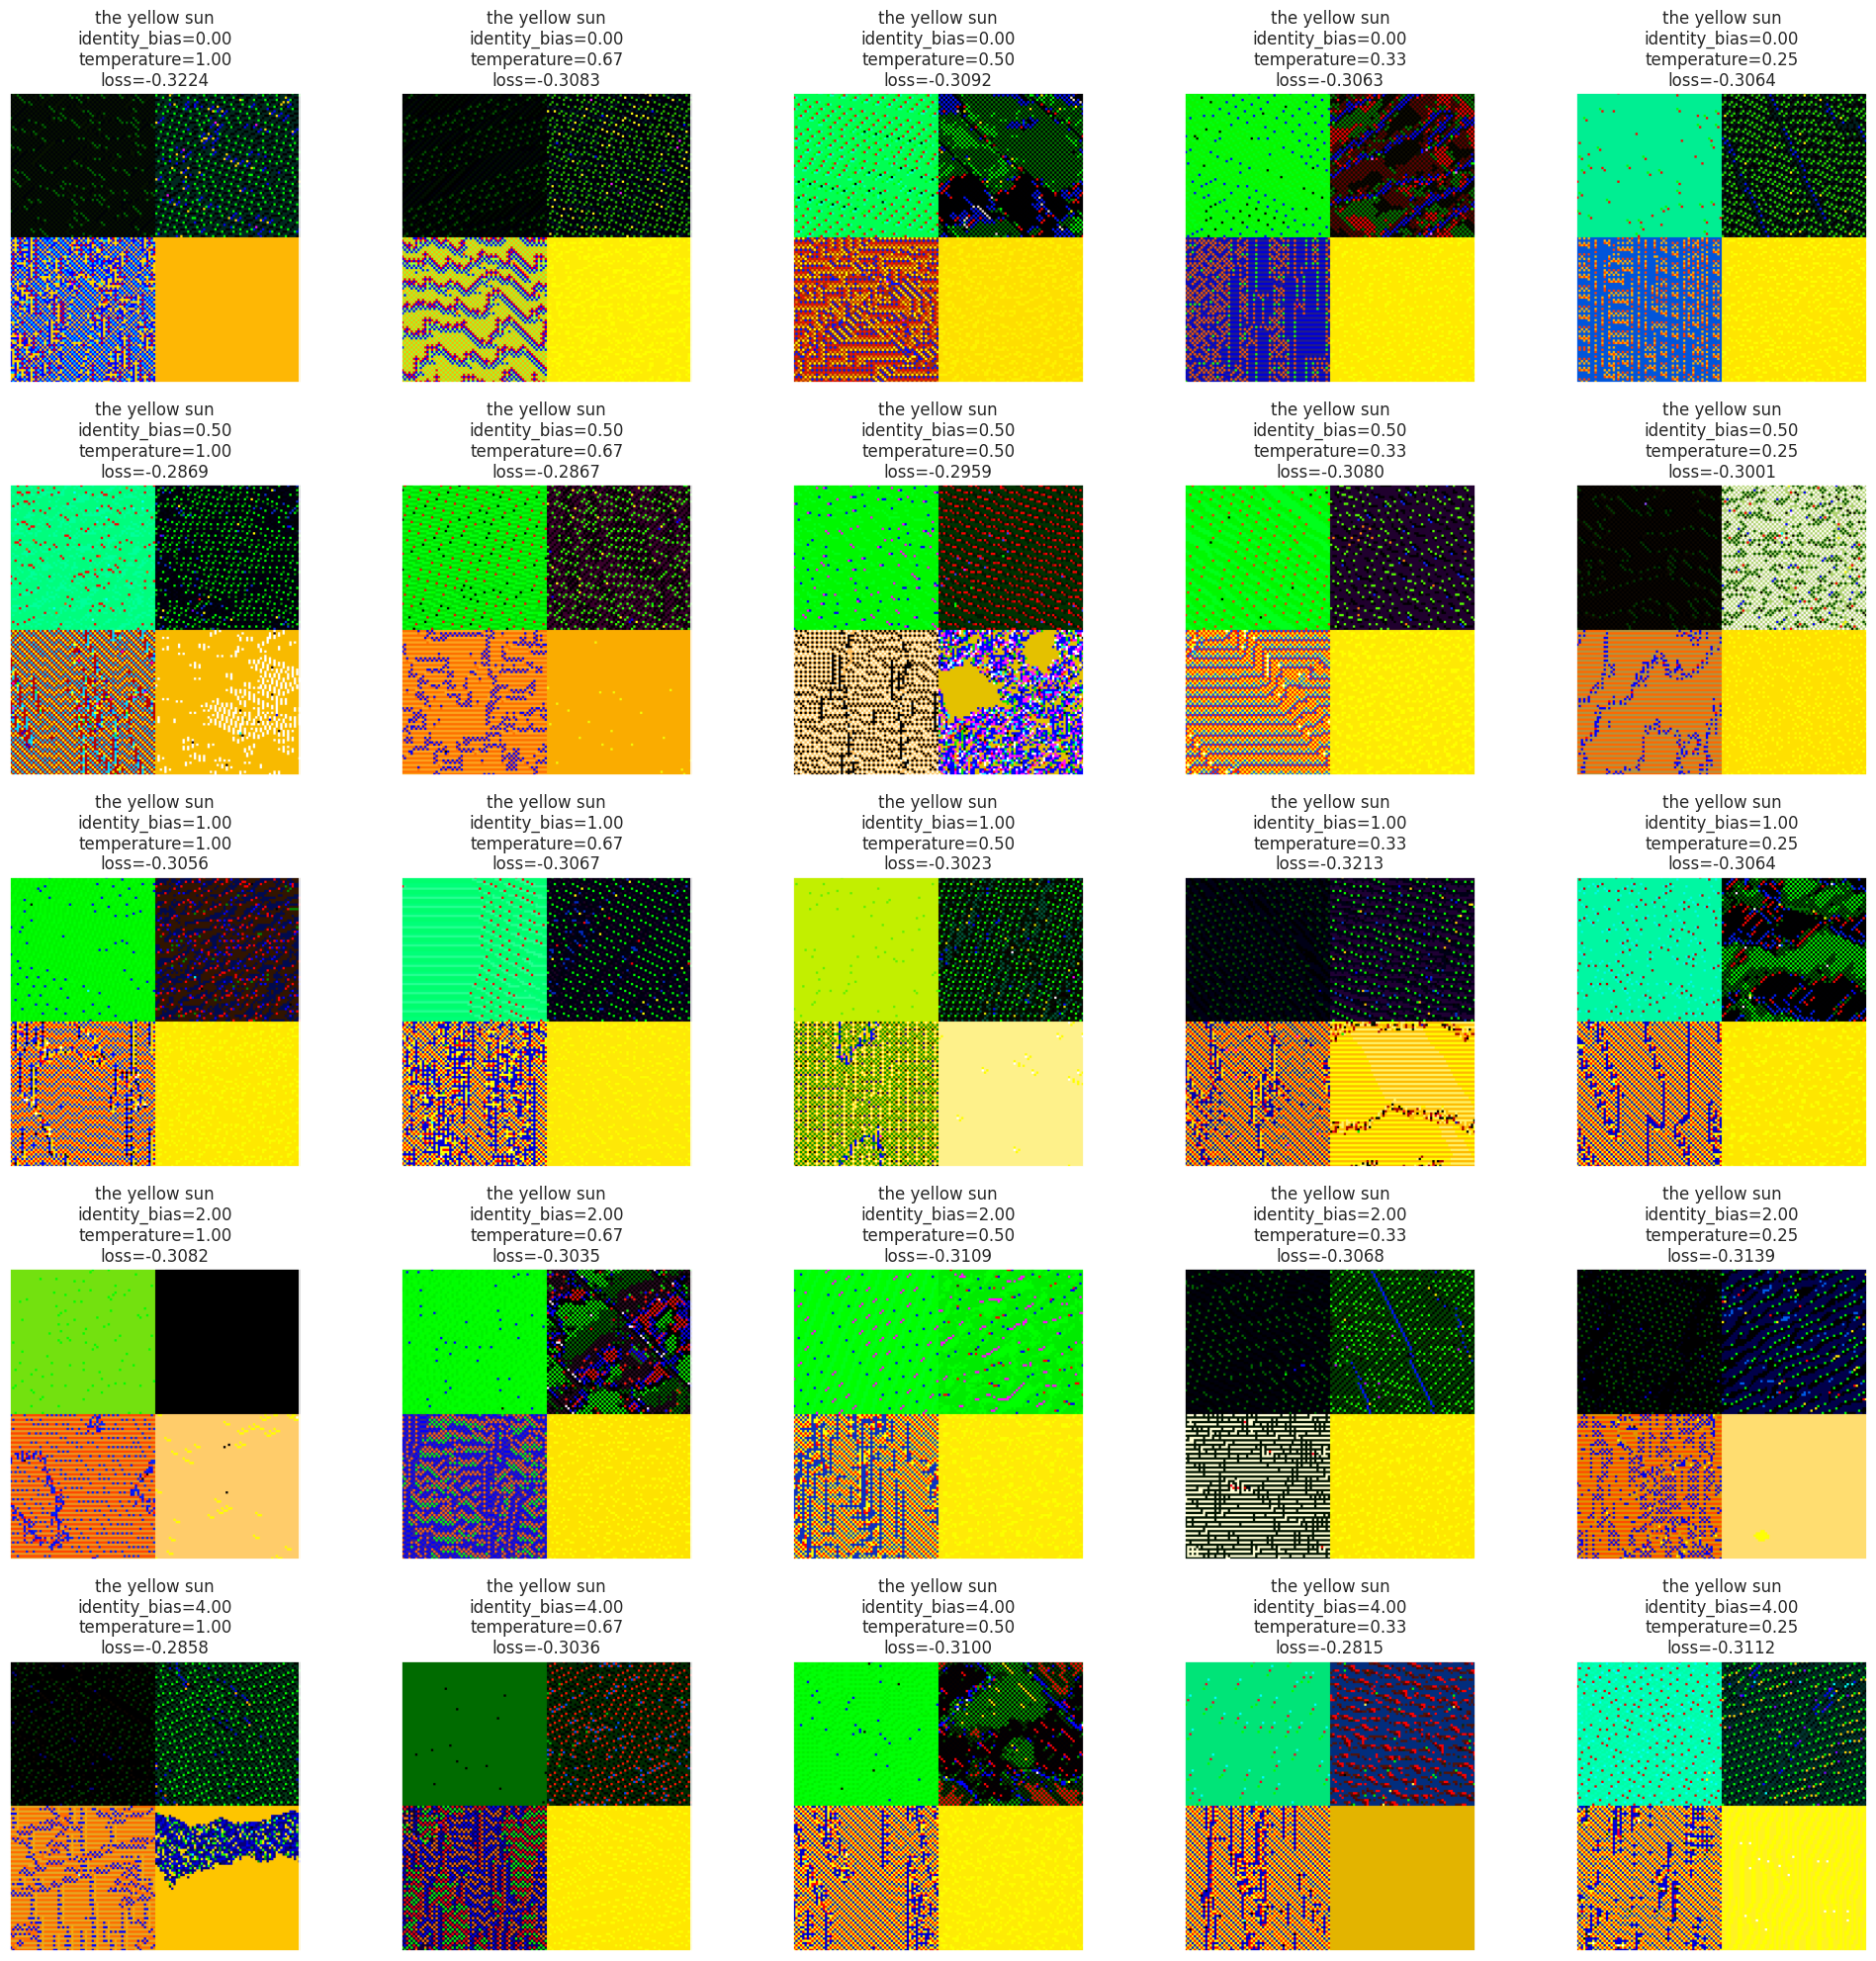

In [58]:
plt.figure(figsize=(20, 20))
iplt = 0
for identity_bias in tqdm(identity_bias_sweep):
    for temperature in temperature_sweep:
        img = []
        for i1, prompts in enumerate(prompts_sweep):
            save_dir=f"/home/akarshkumar0101/nca-alife-data/dnca_1/{seed}_{i1}_{identity_bias}_{temperature}"
            vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)

            img.append(vid[511])
    
            params, loss = util.load_pkl(save_dir, 'best')
            loss = loss.item()
            
        img = np.stack(img)
        # print(img.shape)
        iplt+=1
        plt.subplot(5, 5, iplt)
        plt.imshow(rearrange(img, "(R C) H W D -> (R H) (C W) D", R=2))
        plt.grid(False); plt.xticks([]); plt.yticks([])
        plt.title(f"{prompts}\n{identity_bias=:.2f}\n{temperature=:.2f}\n{loss=:.4f}")

plt.tight_layout()
plt.show()
        

In [59]:
prompts_sweep

['a biological cell',
 'a diverse ecosystem of cells moving around',
 'the game of life cellular automaton',
 'the yellow sun']

  0%|          | 0/5 [00:00<?, ?it/s]

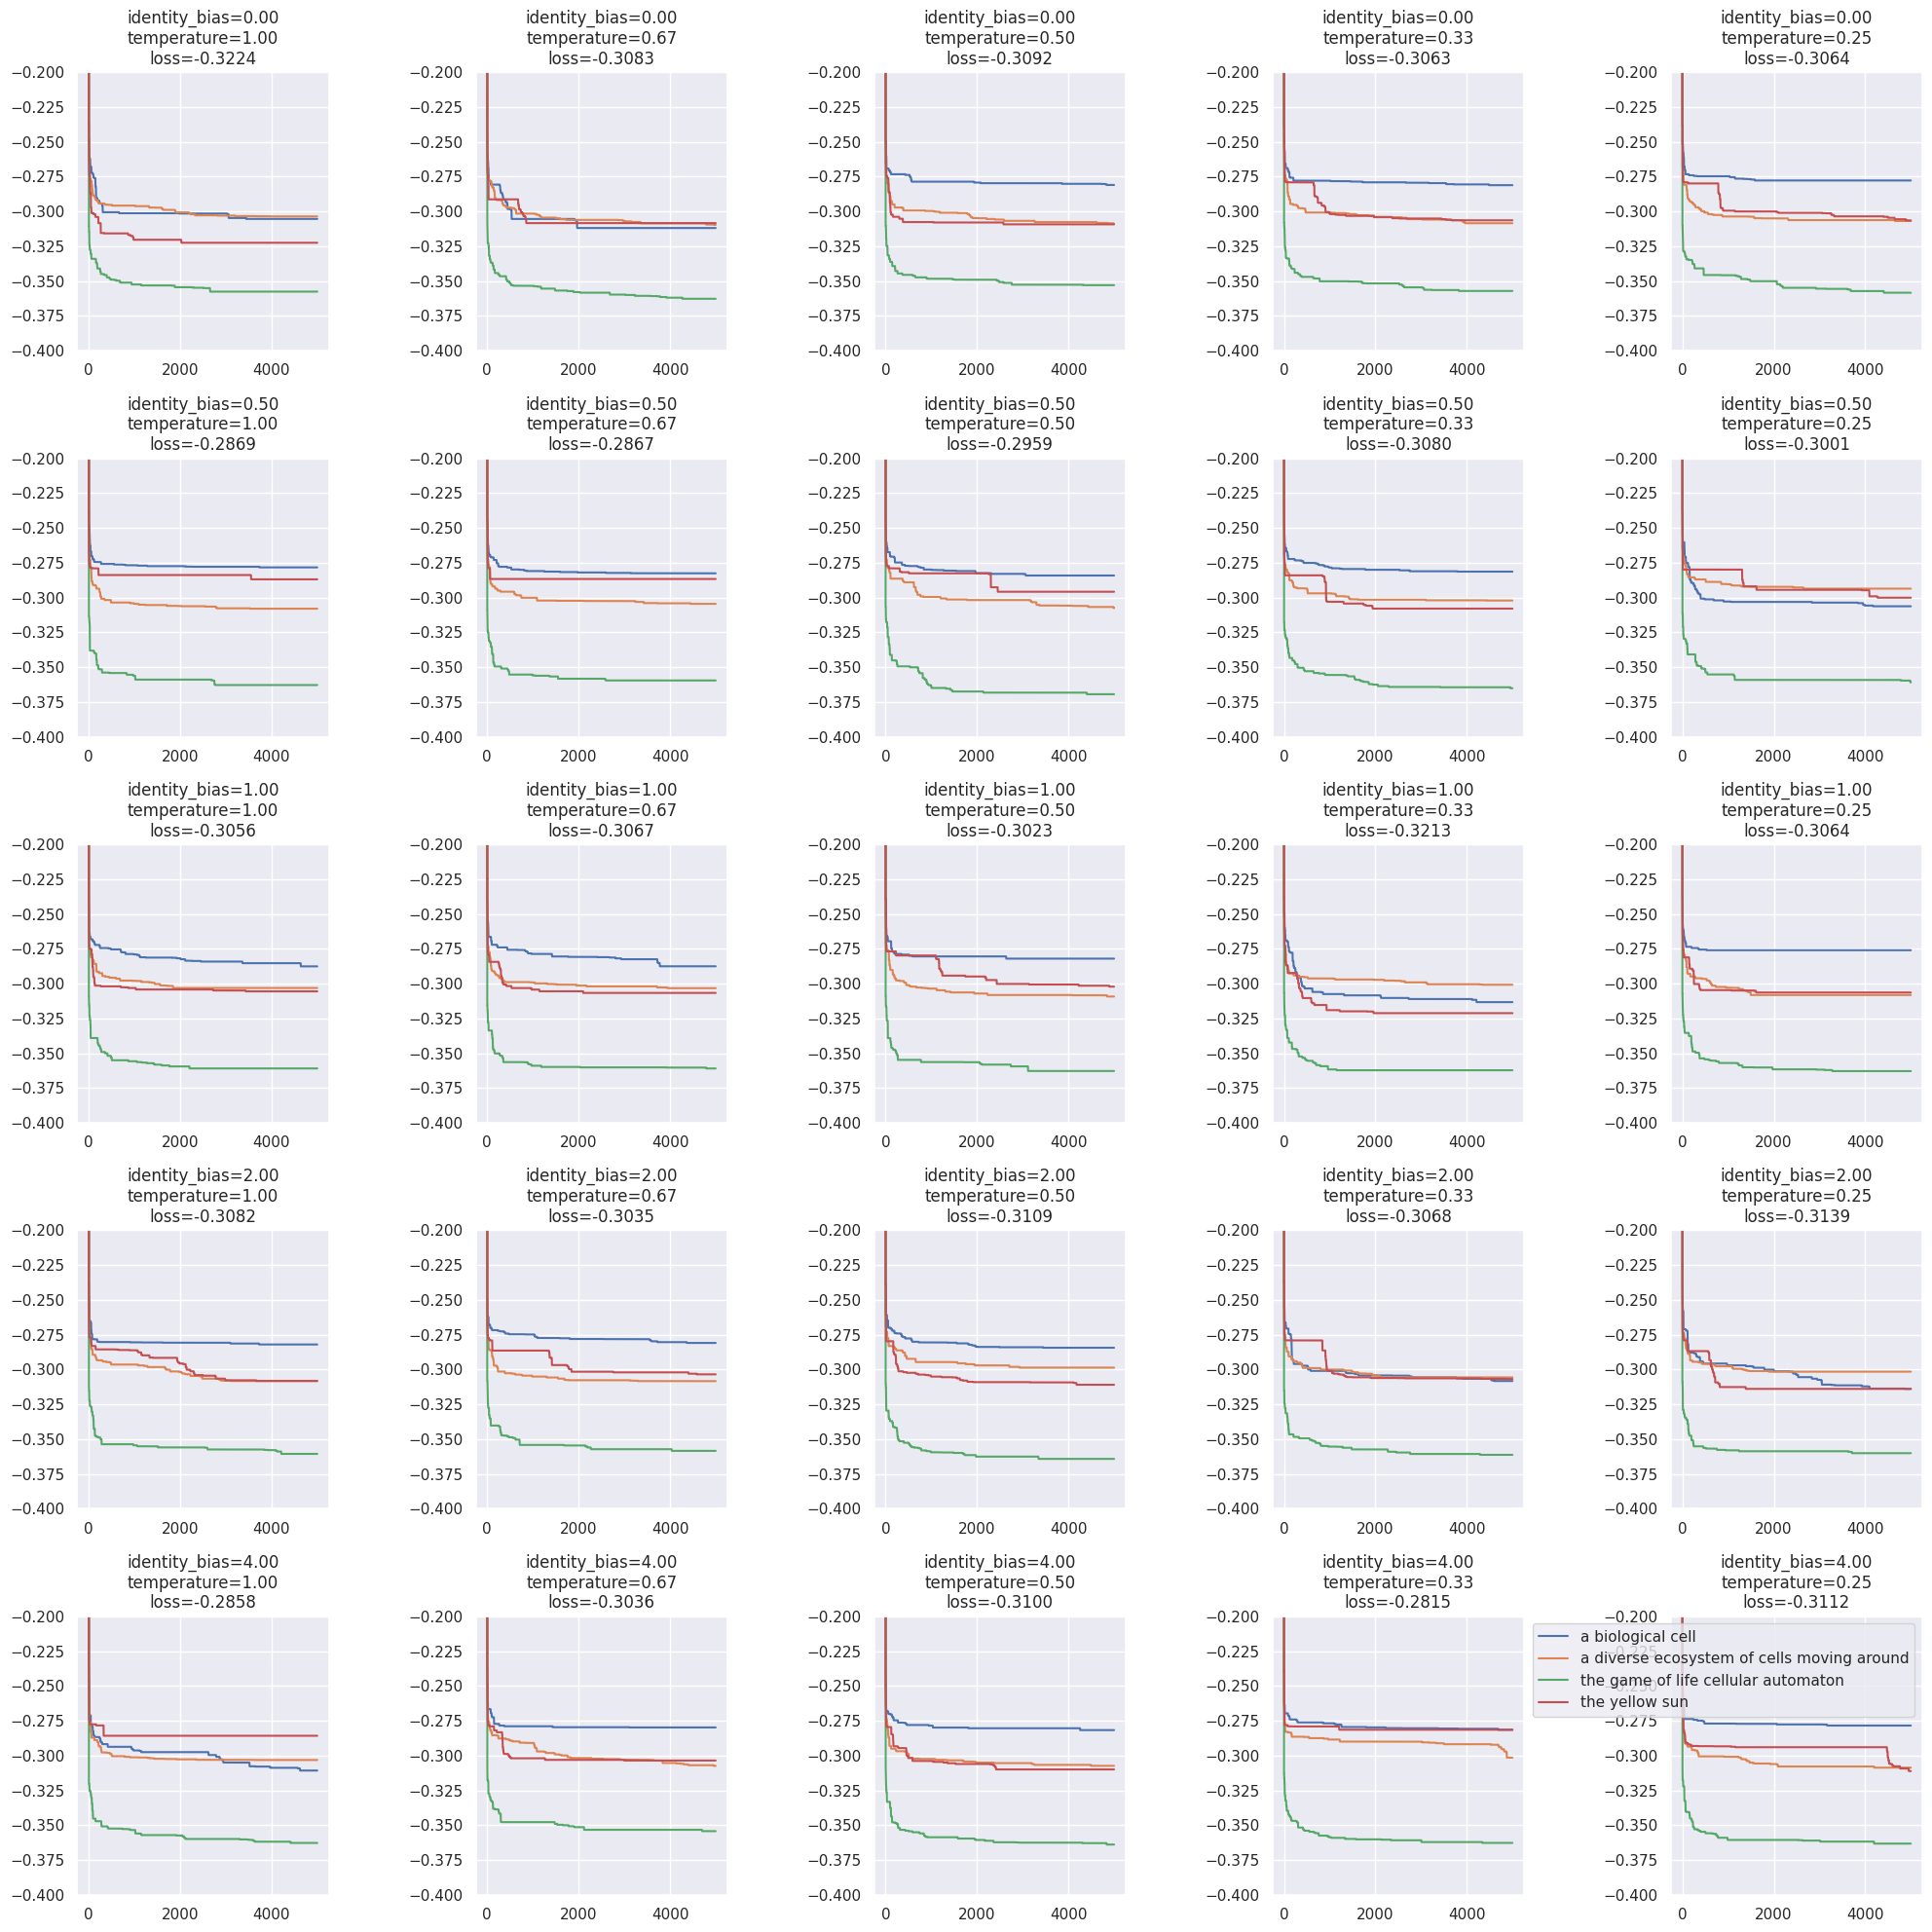

In [60]:
plt.figure(figsize=(20, 20))
iplt = 0
for identity_bias in tqdm(identity_bias_sweep):
    for temperature in temperature_sweep:
        iplt+=1
        plt.subplot(5, 5, iplt)
        for i1, prompts in enumerate(prompts_sweep):
            save_dir=f"/home/akarshkumar0101/nca-alife-data/dnca_1/{seed}_{i1}_{identity_bias}_{temperature}"
            data = util.load_pkl(save_dir, 'data')
            params, loss = util.load_pkl(save_dir, 'best')
            loss = loss.item()
            
            plt.plot(data['best_loss'], label=prompts)
        # plt.grid(False); plt.xticks([]); plt.yticks([])
        plt.title(f"{identity_bias=:.2f}\n{temperature=:.2f}\n{loss=:.4f}")
        plt.ylim(-.4, -.2)

plt.legend()
plt.tight_layout()
plt.show()
        